Exercise is meant for you to experiment with cython and numba to see how much efficiency can be obtained by using these two tools

In [1]:
import numpy as np
import seaborn as sb
import pandas as pd

In [3]:
class Particle:
  def __init__(self, x, y, ang_speed):
    self.x = x
    self.y = y
    self.ang_speed = ang_speed

In [19]:
def evolve_wrapper(dt, particles):
  timestep = 1
  nsteps = int(dt/timestep)
  r_i = np.array([[p.x, p.y] for p in particles])
  ang_speed = np.array([p.ang_speed for p in particles])
  evolve(r_i, ang_speed, timestep, nsteps)

  for i, p in enumerate(particles):
    p.x, p.y = r_i[i]

def evolve(r_i, ang_speed, timestep, nsteps):
  v_i = np.empty_like(r_i)
  for i in range(nsteps):
    norm_i = np.sqrt((r_i ** 2).sum(axis=1))
    v_i = r_i[:, [1,0]]
    v_i[:, 0] *= -1
    v_i /= norm_i[:, np.newaxis]
    d_i = timestep * ang_speed[:, np.newaxis] * v_i

    r_i += d_i

In [20]:
n_particle = 100
coord = np.random.randn(n_particle, 3)
particles = []
for i in range(0, n_particle):
  particles.append(Particle(coord[i][0], coord[i][1], coord[i][2]))

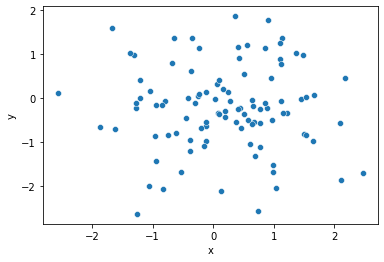

In [6]:
sb.scatterplot(x='x', y='y', data=pd.DataFrame([[p.x,p.y] for p in particles],columns = ['x', 'y']))

In [21]:
evolve_wrapper(10000, particles)

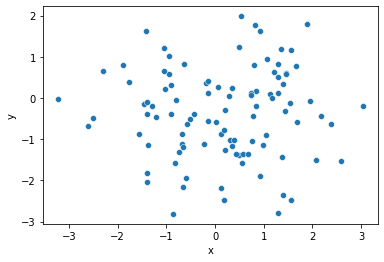

In [8]:
sb.scatterplot(x='x', y='y', data=pd.DataFrame([[p.x,p.y] for p in particles],columns = ['x', 'y']))

In [22]:
%timeit evolve_wrapper(10000, particles)

332 ms ± 45.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Can you rewrite the evolve method to make it faster?

In [10]:
import cython
%load_ext Cython

In [24]:
def c_evolve_wrapper(dt, particles):
  timestep = 1
  nsteps = int(dt/timestep)
  r_i = np.array([[p.x, p.y] for p in particles])
  ang_speed = np.array([p.ang_speed for p in particles])
  c_evolve(r_i, ang_speed, timestep, nsteps)

  for i, p in enumerate(particles):
    p.x, p.y = r_i[i]

In [25]:
%%cython

from libc.math cimport sqrt

def c_evolve(double[:, :] r_i, double[:] ang_speed, double timestep, int nsteps):
  cdef int i, j
  cdef int n_particles = r_i.shape[0]
  cdef double x, y, ang_speed_j, vx, vy, dx, dy
  
  for i in range(nsteps):
    for j in range(n_particles):
      x = r_i[j, 0]
      y = r_i[j, 1]
      ang_speed_j = ang_speed[j]

      norm = sqrt(x ** 2 + y ** 2)

      vx = -y / norm
      vy = x / norm

      dx = timestep * ang_speed_j * vx
      dy = timestep * ang_speed_j * vx

      r_i[j, 0] += dx
      r_i[j, 1] += dy


In [27]:
%timeit c_evolve_wrapper(10000, particles)

72.1 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
